Import libraries CSVs for further research:

In [1]:
# dataframes
import pandas as pd

# math, statistics
import math
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.formula.api import ols
from patsy import dmatrices

# visualizations
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_2015 = pd.read_csv('kc_house_data.csv', parse_dates=['date']) #pre-cleaned data
df_trends = pd.read_csv('market_trend.csv') #2005 to 2020 housing trends
df_link = pd.read_csv('light_rail.csv') #light rail data

# Basic Data Pre-Processing

## Link Light Rail Data Set

Light Rail has existed in King County since 2009, and we believe that proximity to a Link Light Rail station will have a positive impact on housing price. For this reason, the first set of data we'll work on cleaning is a manually gathered link of Light Rail locations by zip code.

In [2]:
print('Link Light Rail Data Set Starting Shape: ', df_link.shape)
df_link.head()

Link Light Rail Data Set Starting Shape:  (55, 8)


,Unnamed: 0,Zip Code,Is Open,Open,Is Started,Construction Started,Is Announced,Announced
0,Beacon Hill,98144.0,True,2009,True,2002.0,True,1996
1,Columbia City,98108.0,True,2009,True,2002.0,True,1996
2,International District/Chinatown,98104.0,True,2009,True,2002.0,True,1996
3,Mount Baker,98144.0,True,2009,True,2002.0,True,1996
4,Othello,98118.0,True,2009,True,2002.0,True,1996


In [3]:
# drop rows where only a vote has occurred (no formal location)
df_link.dropna(subset=['Construction Started'], inplace=True)

# convert all floats to integers
df_link['Zip Code'] = df_link['Zip Code'].astype(int)
df_link['Open'] = df_link['Open'].astype(int)
df_link['Construction Started'] = df_link['Construction Started'].astype(int)
df_link['Announced'] = df_link['Announced'].astype(int) 
df_link['Is Open'] = df_link['Is Open'].astype(int)
df_link['Is Started'] = df_link['Is Started'].astype(int)
df_link['Is Announced'] = df_link['Is Announced'].astype(int) 

# only one row per zip code
df_link.drop_duplicates(subset=['Zip Code'],inplace=True)

# drop station name (unnecessary with cleaned data)
df_link = df_link.loc[:, ~df_link.columns.str.contains('^Unnamed')]

# rename remaining columns for clarity
df_link = df_link.rename(columns = {'Zip Code':'Zip Code','Is Open':'Link Open Nearby','Open':'Year Link Opened','Is Started':'Link Construction Started','Construction Started':'Year Construction Started','Is Announced':'Link Announced','Announced':'Year Link Announced'})

df_link = df_link[['Zip Code','Link Open Nearby','Link Construction Started','Link Announced']]

df_link.head()


,Zip Code,Link Open Nearby,Link Construction Started,Link Announced
0,98144,1,1,1
1,98108,1,1,1
2,98104,1,1,1
4,98118,1,1,1
7,98188,1,1,1


## 2015 to 2019 Price Trend Data

In [4]:
print('Local Sales Trends Data Set Starting Shape: ', df_trends.shape)
df_trends.head()

Local Sales Trends Data Set Starting Shape:  (66382, 12)


,Year,Zip Code,Closings,Sale Amt Avg,YoY Sale Amt Avg,Price/ SqFt Avg,YoY Price/SqFt Avg,Bedrooms Avg,Bathrooms Avg,Living SqFt Avg,Land SqFt Avg,Acres Avg
0,2005.0,98001.0,795,"$266,377.72",NaN,$141.97,NaN,3.5,2.5,"1,984","14,078",0.3
1,2006.0,98001.0,720,"$303,222.23",13.83%,$168.31,18.56%,3.4,2.4,"2,079","20,048",0.5
2,2007.0,98001.0,555,"$326,455.64",7.66%,$183.87,9.24%,3.4,2.4,"1,937","24,975",0.6
3,2008.0,98001.0,359,"$310,835.43",-4.78%,$168.36,-8.44%,3.2,2.2,"1,983","18,185",0.4
4,2009.0,98001.0,413,"$253,008.68",-18.60%,$146.27,-13.12%,3.2,2.2,"1,884","22,121",0.5


In [5]:
# keep only 2015 and 2019 values
values_2015 = ['2015']
df_2015avg = df_trends[df_trends.Year.isin(values_2015)]
values_2019 = ['2019']
df_2019avg = df_trends[df_trends.Year.isin(values_2019)]
df_5comb = pd.merge(df_2015avg, df_2019avg, left_on ='Zip Code', right_on = 'Zip Code', how='left')

# drop blanks rows
df_5comb.dropna(subset=['Year_x'], inplace=True)
df_5comb.dropna(subset=['Year_y'], inplace=True)

# convert all floats to integers
df_5comb['Year_x'] = df_5comb['Year_x'].astype(int)
df_5comb['Year_y'] = df_5comb['Year_y'].astype(int)
df_5comb['Zip Code'] = df_5comb['Zip Code'].astype(int)
df_5comb[' Sale Amt Avg _x'] = df_5comb[' Sale Amt Avg _x'].str.replace(',', '').str.replace('$', '').astype(float)
df_5comb[' Sale Amt Avg _y'] = df_5comb[' Sale Amt Avg _y'].str.replace(',', '').str.replace('$', '').astype(float)

# created simplified DF
df_5yoy = df_5comb[['Zip Code','Year_x',' Sale Amt Avg _x','Year_y',' Sale Amt Avg _y']]

# determine price increase
df_5yoy['Price Increase Multiplier'] = df_5yoy[' Sale Amt Avg _y']/df_5yoy[' Sale Amt Avg _x']

# create final DF to merge with master dataset
df_increase = df_5yoy[['Zip Code','Price Increase Multiplier']]

df_increase.head()

,Zip Code,Price Increase Multiplier
0,98001,1.370913
1,98002,1.442513
2,98003,1.479901
3,98004,1.410100
4,98005,1.488590


## King County Housing Data Set (2015) 

The first thing we will do is capture the original data frame shape to ensure that it doesn't change in lengths as we add additional columns.

In [6]:
print('Starting DataFrame Shape: ', df_2015.shape)

Starting DataFrame Shape:  (21597, 21)


Because we will be doing joins on Zip Code, we want to make sure that the data types match.

### Attila's Cleaning

In [7]:
# convert any question marks to 0
# convert sqft to int

df_2015.loc[df_2015.sqft_basement == '?', 'sqft_basement'] = 0
df_2015['sqft_basement'] = df_2015.sqft_basement.astype(float)
df_2015['sqft_basement'] = df_2015.sqft_basement.astype(int)

In [8]:
# I looked through the data and found a huge outlier 33 bedroom house
# It also has low number of bathrooms, sqft_living so it was probably a data entry error

#this no longer works to remove the outlier
#.loc bedroom = 33 to pull off

In [9]:
# converting dates to specified format
# which will then be used to create seasons

df_2015['date'] = pd.to_datetime(df_2015['date'], format='%m/%d/%Y', errors='coerce')
df_2015['month'] = df_2015['date'].dt.month
season = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'fall',
    10: 'fall',
    11: 'fall',
    12: 'winter',
}
df_2015['season'] = df_2015['month'].replace(season)
df_season = pd.get_dummies(df_2015['season'], drop_first=True)
df_2015 = pd.concat([df_2015, df_season], axis=1)
df_2015.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,month,season,spring,summer,winter
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,98178,47.5112,-122.257,1340,5650,10,fall,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,98125,47.7210,-122.319,1690,7639,12,winter,0,0,1
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,98028,47.7379,-122.233,2720,8062,2,winter,0,0,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,98136,47.5208,-122.393,1360,5000,12,winter,0,0,1
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,98074,47.6168,-122.045,1800,7503,2,winter,0,0,1


In [10]:
df_2015['zipcode'] = df_2015['zipcode'].astype(int)
df_2015['renovated'] = (df_2015['yr_renovated'] > 0).astype(int)
df_2015['basement'] = (df_2015['sqft_basement'] > 0).astype(int)
df_2015['price'] = df_2015['price'].astype(int)

Then, we will add our Link Light Rail data.

In [11]:
# merge with Link data
df_with_Link = pd.merge(df_2015, df_link, left_on ='zipcode', right_on = 'Zip Code', how='left')

#fill NaN values
df_with_Link['Link Open Nearby'].fillna(value=0, inplace=True)
df_with_Link['Link Construction Started'].fillna(value=0, inplace=True)
df_with_Link['Link Announced'].fillna(value=0, inplace=True)

print('New DataFrame Shape with Link Data:', df_with_Link.shape)
df_with_Link.head()

New DataFrame Shape with Link Data: (21597, 32)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,season,spring,summer,winter,renovated,basement,Zip Code,Link Open Nearby,Link Construction Started,Link Announced
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,NaN,0.0,...,fall,0,0,0,0,0,NaN,0.0,0.0,0.0
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,winter,0,0,1,1,1,98125.0,0.0,1.0,1.0
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0.0,0.0,...,winter,0,0,1,0,0,NaN,0.0,0.0,0.0
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,winter,0,0,1,0,1,NaN,0.0,0.0,0.0
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,winter,0,0,1,0,0,NaN,0.0,0.0,0.0


In [12]:
# merge all data
df_2019 = pd.merge(df_with_Link, df_increase, left_on ='zipcode', right_on = 'Zip Code', how='left')
print('New DataFrame Shape with Link and Price Increase:', df_2019.shape)
df_2019.head()

New DataFrame Shape with Link and Price Increase: (21597, 34)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,summer,winter,renovated,basement,Zip Code_x,Link Open Nearby,Link Construction Started,Link Announced,Zip Code_y,Price Increase Multiplier
0,7129300520,2014-10-13,221900,3,1.00,1180,5650,1.0,NaN,0.0,...,0,0,0,0,NaN,0.0,0.0,0.0,98178,1.509747
1,6414100192,2014-12-09,538000,3,2.25,2570,7242,2.0,0.0,0.0,...,0,1,1,1,98125.0,0.0,1.0,1.0,98125,1.437320
2,5631500400,2015-02-25,180000,2,1.00,770,10000,1.0,0.0,0.0,...,0,1,0,0,NaN,0.0,0.0,0.0,98028,1.399279
3,2487200875,2014-12-09,604000,4,3.00,1960,5000,1.0,0.0,0.0,...,0,1,0,1,NaN,0.0,0.0,0.0,98136,1.231594
4,1954400510,2015-02-18,510000,3,2.00,1680,8080,1.0,0.0,0.0,...,0,1,0,0,NaN,0.0,0.0,0.0,98074,1.467197


The first steps before moving forward with further data exploration are:<ol>
<li> Remove non-features, such as id and date. While there may be justification to keep the date column, this would be better suited for market fluctuations over time rather than regression based on housing features.</li>
<li> Check for null values that may skew the data.</li>
<li> Determine whether or not there is categorical data that will require conversion.</li>

In [13]:
# drop columns that were used in transformation
df_2019 = df_2019.drop(['id','date','month','season','sqft_basement','yr_renovated'], axis = 1)

# drop redundant columns that were generated because of table merges
df_2019 = df_2019.drop(['Zip Code_x','Zip Code_y'], axis = 1)

df_2019.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,spring,summer,winter,renovated,basement,Link Open Nearby,Link Construction Started,Link Announced,Price Increase Multiplier
0,221900,3,1.00,1180,5650,1.0,NaN,0.0,3,7,...,5650,0,0,0,0,0,0.0,0.0,0.0,1.509747
1,538000,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,7639,0,0,1,1,1,0.0,1.0,1.0,1.437320
2,180000,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,8062,0,0,1,0,0,0.0,0.0,0.0,1.399279
3,604000,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,5000,0,0,1,0,1,0.0,0.0,0.0,1.231594
4,510000,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,7503,0,0,1,0,0,0.0,0.0,0.0,1.467197


In [14]:
# checking if any value is missing
print(df_2019.isnull().any())

price                        False
bedrooms                     False
bathrooms                    False
sqft_living                  False
sqft_lot                     False
floors                       False
waterfront                    True
view                          True
condition                    False
grade                        False
sqft_above                   False
yr_built                     False
zipcode                      False
lat                          False
long                         False
sqft_living15                False
sqft_lot15                   False
spring                       False
summer                       False
winter                       False
renovated                    False
basement                     False
Link Open Nearby             False
Link Construction Started    False
Link Announced               False
Price Increase Multiplier    False
dtype: bool


In previous steps, we changed yr_renovated to "renovated" and "sqft_basement" to "basement" booleans.

In [15]:
display(df_2019['waterfront'].value_counts(dropna=False))
display(df_2019['view'].value_counts(dropna=False))

0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
NaN       63
Name: view, dtype: int64

In [16]:
# drop view (why would # of views matter for price, it wouldn't)
# for waterfront, assume 0, or drop column? figure out - heat map maybe?

Using Price Increase Multiplier to Predict Current Home Price

In [17]:
df_2019['Est_2020_Price'] = (df_2019['price']*df_2019['Price Increase Multiplier']).round(-3)

In [18]:
df_2019['Est_2020_Price']

0        335000.0
1        773000.0
2        252000.0
3        744000.0
4        748000.0
           ...   
21592    508000.0
21593    589000.0
21594    607000.0
21595    556000.0
21596    491000.0
Name: Est_2020_Price, Length: 21597, dtype: float64

In [19]:
# grab columns for feature testing
df_2019.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'spring',
       'summer', 'winter', 'renovated', 'basement', 'Link Open Nearby',
       'Link Construction Started', 'Link Announced',
       'Price Increase Multiplier', 'Est_2020_Price'],
      dtype='object')

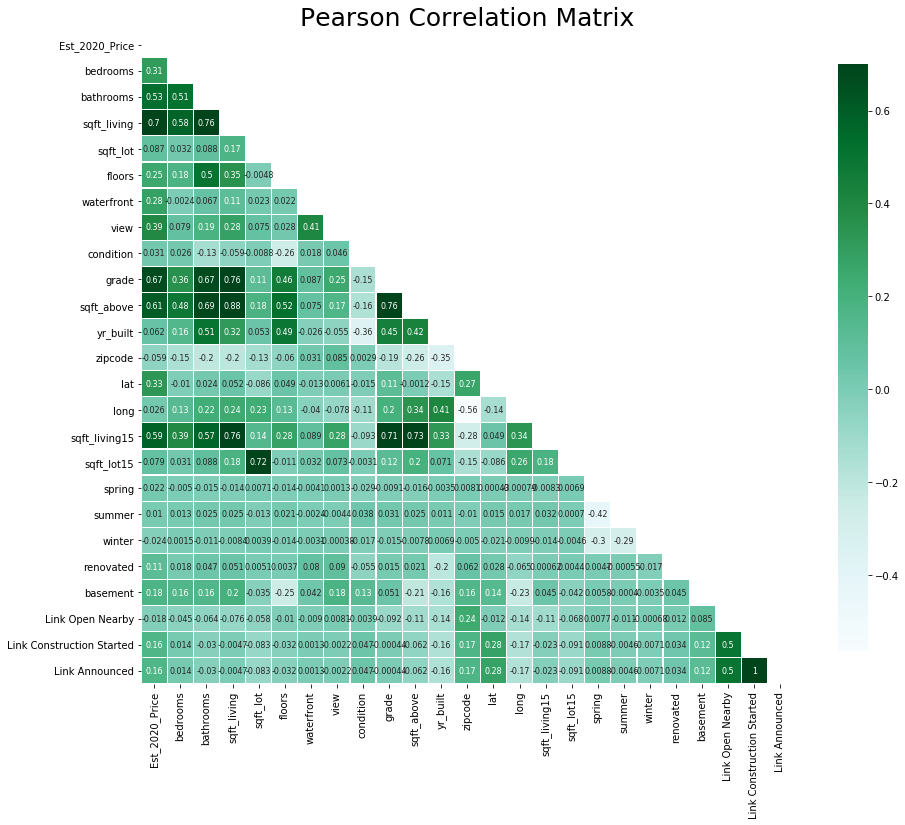

In [20]:
features = ['Est_2020_Price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'spring', 'summer', 'winter', 'renovated', 'basement',
       'Link Open Nearby', 'Link Construction Started', 'Link Announced']

mask = np.zeros_like(df_2019[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_2019[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


In [21]:
# adjusting for sqft_living multi-collinearity
df_2019['sqft_living_mc'] = df_2019['sqft_living']*df_2019['sqft_living15']*df_2019['sqft_above']

# adjusting for sqft_lot multi-collinearity
df_2019['sqft_lot_mc'] = df_2019['sqft_lot']*df_2019['sqft_lot15']

# adjusting for Link multi-collinearity
df_2019['link_mc'] = df_2019['Link Construction Started'] * df_2019['Link Announced']


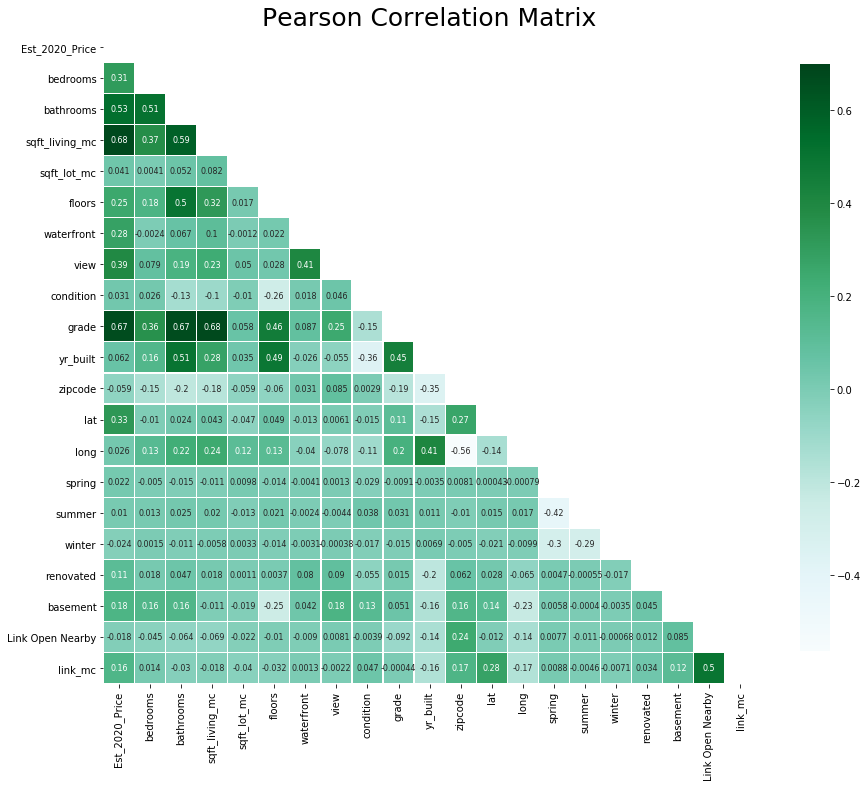

In [22]:
revised_features = ['Est_2020_Price', 'bedrooms', 'bathrooms', 'sqft_living_mc', 'sqft_lot_mc', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built','zipcode', 'lat', 'long',
       'spring', 'summer', 'winter', 'renovated', 'basement','Link Open Nearby', 'link_mc']

mask = np.zeros_like(df_2019[revised_features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_2019[revised_features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [23]:
#we tried to see if zip code really didn't have a correlation, turns out it doesn't

# df_2019price = df_2019['Est 2020 Price']
# df_zip = pd.get_dummies(df_2019['zipcode'], drop_first=True)
# df_zipexp = pd.concat([df_2019price, df_zip], axis=1)

# zip_features = ['Est 2020 Price',            98002,            98003,            98004,
#                   98005,            98006,            98007,            98008,
#                   98010,            98011,            98014,            98019,
#                   98022,            98023,            98024,            98027, 98028,            98029,            98030,            98031,
#                   98032,            98033,            98034,            98038,
#                   98039,            98040,            98042,            98045,
#                   98052,            98053,            98055,            98056,
#                   98058,            98059,            98065,            98070,
#                   98072,            98074,            98075,            98077,
#                   98092,            98102,            98103,            98105,
#                   98106,            98107,            98108,            98109,
#                   98112,            98115,            98116,            98117,
#                   98118,            98119,            98122,            98125,
#                   98126,            98133,            98136,            98144,
#                   98146,            98148,            98155,            98166,
#                   98168,            98177,            98178,            98188,
#                   98198,            98199]

# mask = np.zeros_like(df_zipexp[zip_features].corr(), dtype=np.bool) 
# mask[np.triu_indices_from(mask)] = True 

# f, ax = plt.subplots(figsize=(30, 30))
# plt.title('Pearson Correlation Matrix',fontsize=25)

# sns.heatmap(df_zipexp[zip_features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", 
#             linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

# Multicollinearity

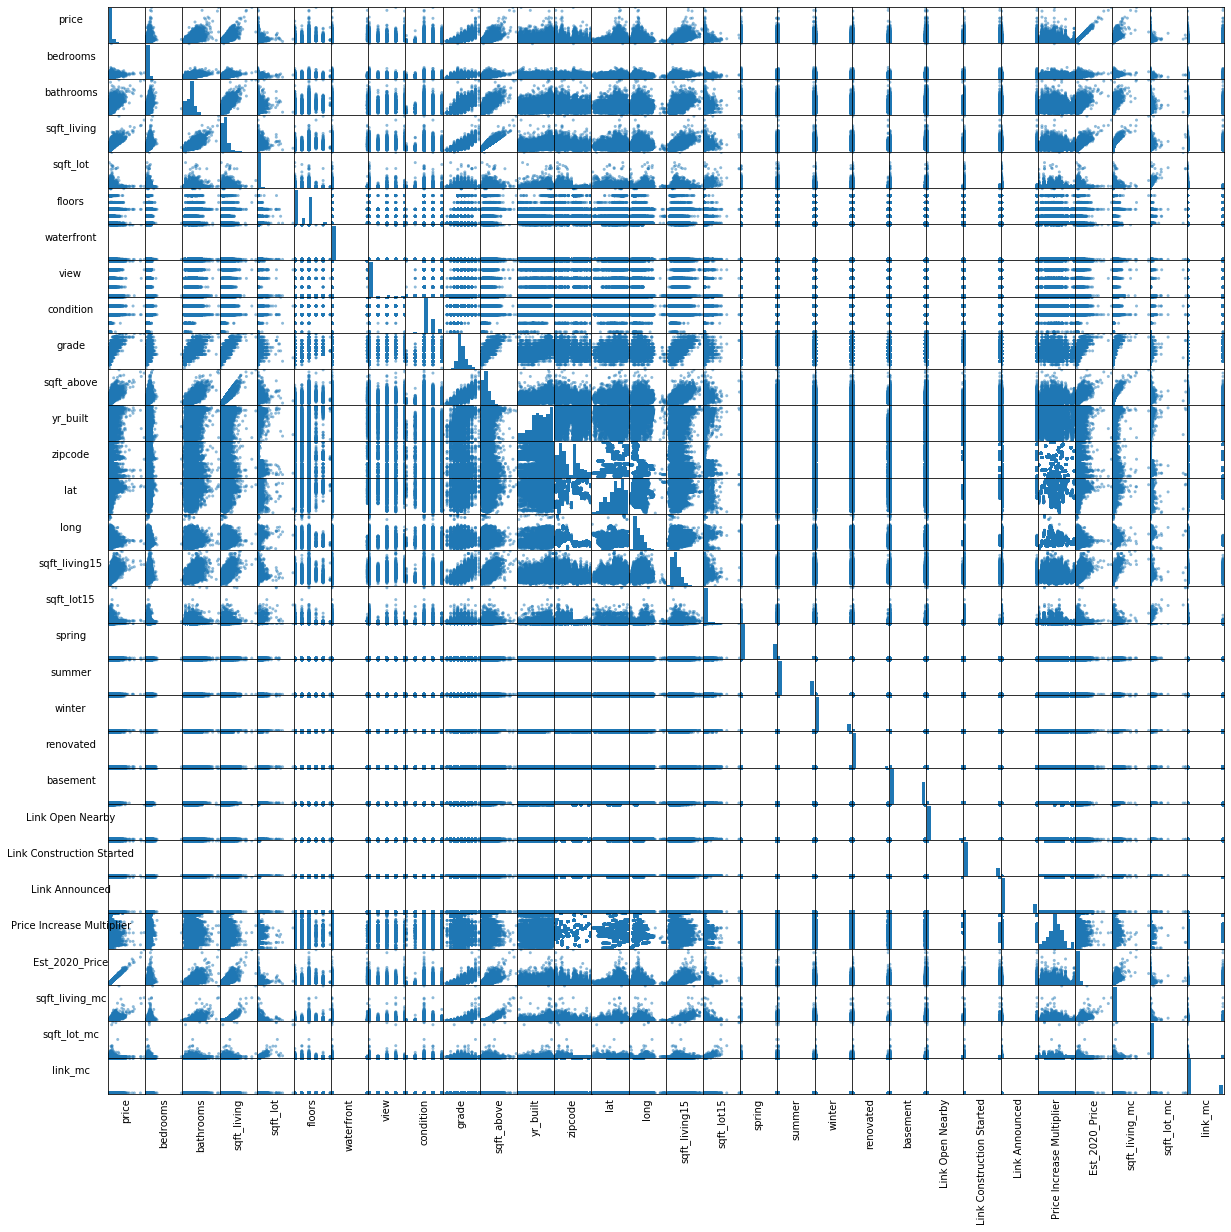

In [24]:
sm = pd.plotting.scatter_matrix(df_2019, figsize=[20, 20]);

[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

In [25]:
df_2019.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,renovated,basement,Link Open Nearby,Link Construction Started,Link Announced,Price Increase Multiplier,Est_2020_Price,sqft_living_mc,sqft_lot_mc,link_mc
price,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,...,0.117543,0.178264,-0.039809,0.154404,0.154404,-0.177043,0.992399,0.678760,0.045480,0.154404
bedrooms,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,...,0.017635,0.158412,-0.044778,0.014066,0.014066,-0.009766,0.313004,0.373127,0.004138,0.014066
bathrooms,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,...,0.046742,0.159863,-0.064368,-0.030324,-0.030324,-0.099854,0.527161,0.587320,0.051613,-0.030324
sqft_living,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,...,0.050829,0.201198,-0.076196,-0.004719,-0.004719,-0.105354,0.703869,0.829831,0.089140,-0.004719
sqft_lot,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,...,0.005091,-0.034889,-0.057912,-0.082661,-0.082661,-0.063769,0.087048,0.164021,0.709482,-0.082661
floors,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,...,0.003713,-0.252465,-0.010177,-0.031806,-0.031806,-0.127788,0.253438,0.322632,0.017199,-0.031806
waterfront,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,...,0.079601,0.041623,-0.009035,0.001293,0.001293,-0.031063,0.283217,0.103806,-0.001205,0.001293
view,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,...,0.090465,0.177478,0.008111,-0.002174,-0.002174,-0.091957,0.393398,0.234359,0.049973,-0.002174
condition,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,...,-0.055383,0.130542,-0.003906,0.047293,0.047293,-0.021777,0.031268,-0.099897,-0.010428,0.047293
grade,0.667951,0.356563,0.665838,0.762779,0.114731,0.458794,0.087383,0.249727,-0.146896,1.000000,...,0.015259,0.050701,-0.092485,-0.000437,-0.000437,-0.139871,0.668089,0.676485,0.058031,-0.000437


In [26]:
abs(df_2019.corr())>.70

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,renovated,basement,Link Open Nearby,Link Construction Started,Link Announced,Price Increase Multiplier,Est_2020_Price,sqft_living_mc,sqft_lot_mc,link_mc
price,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,True,False,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,True,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
floors,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [27]:
df_highcorr = df_2019.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_highcorr['pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
df_highcorr.set_index(['pairs'], inplace = True)
df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
df_highcorr.columns = ['cc']
df_highcorr.drop_duplicates(inplace=True)
df_highcorr[(df_highcorr.cc>.7) & (df_highcorr.cc<1)]

,cc
pairs,
"(Est_2020_Price, price)",0.992399
"(sqft_living, sqft_above)",0.876448
"(sqft_above, sqft_living_mc)",0.830962
"(sqft_living_mc, sqft_living)",0.829831
"(grade, sqft_living)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(grade, sqft_above)",0.756073
"(bathrooms, sqft_living)",0.755758
"(sqft_living15, sqft_living_mc)",0.736257


In [28]:
y, X = dmatrices('Est_2020_Price ~ sqft_living+sqft_above+sqft_living_mc+grade+sqft_living15+bathrooms+sqft_lot+sqft_lot15+sqft_lot_mc', data=df_2019, return_type='dataframe')

In [29]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,72.179396,Intercept
1,6.825034,sqft_living
2,5.502186,sqft_above
3,4.093211,sqft_living_mc
4,2.965893,grade
5,2.872114,sqft_living15
6,2.526876,bathrooms
7,2.495683,sqft_lot
8,2.589921,sqft_lot15
9,2.495315,sqft_lot_mc


In [30]:
#df_2019.drop(columns=['price','sqft_above','sqft_living_mc'], inplace=True)

In [31]:
y, X = dmatrices('Est_2020_Price ~ sqft_living+grade+sqft_living15+bathrooms+sqft_lot+sqft_lot15+sqft_lot_mc', data=df_2019, return_type='dataframe')

In [32]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,61.844205,Intercept
1,4.119746,sqft_living
2,2.820587,grade
3,2.670054,sqft_living15
4,2.473716,bathrooms
5,2.490631,sqft_lot
6,2.585360,sqft_lot15
7,2.493182,sqft_lot_mc


# Interactions 

In [34]:
df_2019['rooms_interact'] = df_2019['bedrooms'] * df_2019['bathrooms']
df_2019['sqft_interact'] = df_2019['sqft_living'] * df_2019['sqft_lot']
df_2019

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,yr_built,...,basement,Link Open Nearby,Link Construction Started,Link Announced,Price Increase Multiplier,Est_2020_Price,sqft_lot_mc,link_mc,rooms_interact,sqft_interact
0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1955,...,0,0.0,0.0,0.0,1.509747,335000.0,31922500,0.0,3.00,6667000
1,3,2.25,2570,7242,2.0,0.0,0.0,3,7,1951,...,1,0.0,1.0,1.0,1.437320,773000.0,55321638,1.0,6.75,18611940
2,2,1.00,770,10000,1.0,0.0,0.0,3,6,1933,...,0,0.0,0.0,0.0,1.399279,252000.0,80620000,0.0,2.00,7700000
3,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1965,...,1,0.0,0.0,0.0,1.231594,744000.0,25000000,0.0,12.00,9800000
4,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1987,...,0,0.0,0.0,0.0,1.467197,748000.0,60624240,0.0,6.00,13574400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,3,2.50,1530,1131,3.0,0.0,0.0,3,8,2009,...,0,0.0,0.0,0.0,1.410917,508000.0,1706679,0.0,7.50,1730430
21593,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2014,...,0,0.0,0.0,0.0,1.472291,589000.0,41853600,0.0,10.00,13428030
21594,2,0.75,1020,1350,2.0,0.0,0.0,3,7,2009,...,0,1.0,1.0,1.0,1.510212,607000.0,2709450,1.0,1.50,1377000
21595,3,2.50,1600,2388,2.0,NaN,0.0,3,8,2004,...,0,0.0,0.0,0.0,1.388781,556000.0,3073356,0.0,7.50,3820800


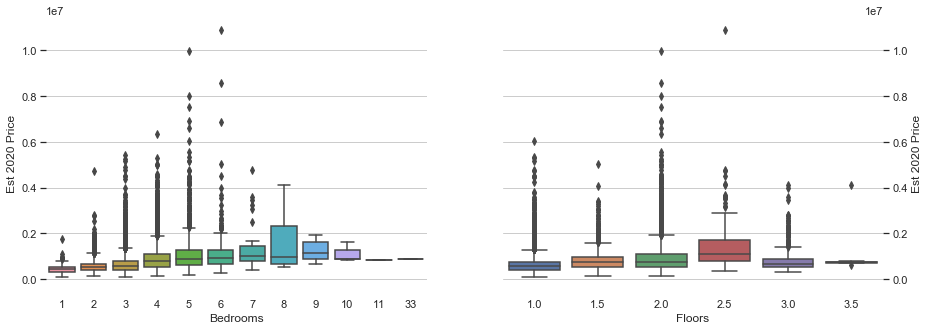

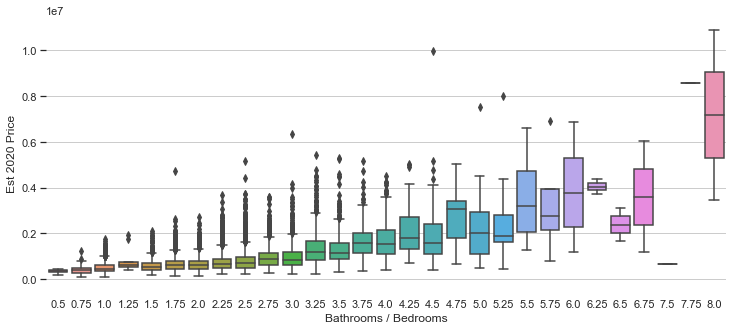

In [39]:
sns.set(style="whitegrid", font_scale=1)
f, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df_2019['bedrooms'],y=df_2019['Est 2020 Price'], ax=axes[0])
sns.boxplot(x=df_2019['floors'],y=df_2019['Est 2020 Price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Bedrooms', ylabel='Est 2020 Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='Floors', ylabel='Est 2020 Price')

f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.despine(left=True, bottom=True)
sns.boxplot(x=df_2019['bathrooms'],y=df_2019['Est 2020 Price'], ax=axe)
axe.yaxis.tick_left()
axe.set(xlabel='Bathrooms / Bedrooms', ylabel='Est 2020 Price');


In [40]:
, axes = plt.subplots(1, 2,figsize=(15,5))
sns.boxplot(x=df_2019['waterfront'],y=df_2019['Est 2020 Price'], ax=axes[0])
sns.boxplot(x=df_2019['view'],y=df_2019['Est 2020 Price'], ax=axes[1])
sns.despine(left=True, bottom=True)
axes[0].set(xlabel='Waterfront', ylabel='Price')
axes[0].yaxis.tick_left()
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set(xlabel='View', ylabel='Price');

<Figure size 432x288 with 0 Axes>

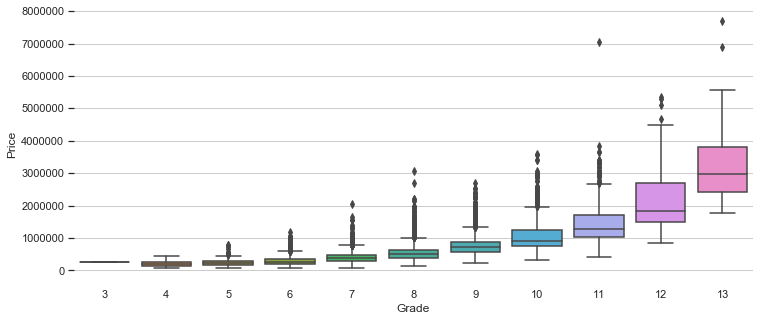

In [41]:
f, axe = plt.subplots(1, 1,figsize=(12.18,5))
sns.boxplot(x=df_2019['grade'],y=df_2019['price'], ax=axe)
sns.despine(left=True, bottom=True)
axe.yaxis.tick_left()
axe.set(xlabel='Grade', ylabel='Price');

Chi-Sqaure Analysis

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
fit_X = df_2019[['bedrooms', 'bathrooms', 'sqft_living_mc', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'yr_built',
       'zipcode','spring', 'summer', 'winter', 'renovated', 'basement',
       'Link Open Nearby', 'Link Construction Started', 'Link Announced']] 
fit_y = df_2019['Est 2020 Price'].to_list()
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(fit_X,fit_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(fit_X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

We can also run a correlation heat map:

In [ ]:
Train Model

In [ ]:
X = df_concat[['as_wins','as_lipsync_wins','os_as_age_gap','as_highs']].values
y = df_concat[['as_placement']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
Determine Model Accuracy

In [ ]:
SVC_model = svm.SVC(random_state=0)
SVC_model.fit(X_train, y_train.ravel())
SVC_prediction = SVC_model.predict(X_test)
print("Support Vector Machine Accuracy:", accuracy_score(SVC_prediction, y_test))

GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train.ravel())
GNB_prediction = GNB_model.predict(X_test)
print("Gausian Naive Bayes Accuracy:", accuracy_score(GNB_prediction, y_test))

LR_model = LogisticRegression(max_iter=10000, random_state=0)
LR_model.fit(X_train, y_train.ravel())
LR_prediction = LR_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(LR_prediction, y_test))

RFC_model = RandomForestClassifier(random_state=0)
RandomForestClassifier()
RFC_model.fit(X_train, y_train.ravel())
RFC_prediction = RFC_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(RFC_prediction, y_test))

KNN_model = KNeighborsClassifier(n_neighbors=7)
KNN_model.fit(X_train, y_train.ravel())
KNN_prediction = KNN_model.predict(X_test)
print("K Nearest Neighbor Accuracy:", accuracy_score(KNN_prediction, y_test), 
      "(Note: Elbow Method for Optimal K was Used)")

LDA_model = LinearDiscriminantAnalysis()
LDA_model.fit(X_train, y_train.ravel())
LDA_prediction = LDA_model.predict(X_test)
print("Linear Discriminant Analysis Accuracy:", accuracy_score(LDA_prediction, y_test))

In [ ]:
Set Final Model

In [ ]:
Final_model = LinearDiscriminantAnalysis()
Final_model.fit(X, y.ravel())